In [1]:
import torch
import torchsde
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import statsmodels.api as sm
import matplotlib.pyplot as plt
from plots import histogram
from loss import sigmoid

# Heston Process

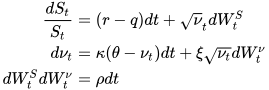

In [2]:
NUM_DAYS = 10 * 365
NUM_TIMES = 10
VOLATILITY_SPAN = 30
NUM_STRIKES = 100

The idea is to train a model that learns to distinguish between
* real-world stock prices
* Heston-SDE paths

Each Heston-SDE path is associated with an $(r, q, \kappa, \theta, \xi, \rho)$ and therefore the model would implicitly give the likelihood of this tuple.

In [3]:
class Heston(torch.nn.Module):

    noise_type = 'general'
    sde_type = 'ito'
    state_size = 2
    brownian_size = 1

    def __init__(self, sample_size, r=1e-2, kappa=.02, theta=.02, xi=.5, q=0.0, rho=-.75):
        super().__init__()
        self.r = torch.nn.Parameter(torch.tensor(r))
        self.q = torch.nn.Parameter(torch.tensor(q))
        self.kappa = torch.nn.Parameter(torch.tensor(kappa))
        self.theta = torch.nn.Parameter(torch.tensor(theta))
        self.xi = torch.nn.Parameter(torch.tensor(xi))
        self.rho = torch.nn.Parameter(torch.tensor(rho))  # TODO
        self.sample_size = sample_size

    def f(self, t, y):
        multiplicator = torch.tensor([self.r - self.q, - self.kappa])
        summand = torch.tensor([0, self.kappa * self.theta])
        drift = torch.mul(multiplicator, y)
        drift += summand
        return drift.view(self.sample_size, self.state_size)

    def g(self, t, y):
        diffusion_1 = torch.sqrt(y[:, -1])
        diffusion_2 = self.xi * torch.sqrt(y[:, -1])
        diffusion = torch.stack([diffusion_1, diffusion_2], dim=-1)
        return diffusion.view(self.sample_size, self.state_size, self.brownian_size)


In [4]:
def get_prices(ticker):
    start, end = datetime.today() - timedelta(days=NUM_DAYS), datetime.today()
    ticker_data = yf.download(ticker, start=start, end=end)
    ticker_data["Instant Volatility"] = ticker_data["Adj Close"].pct_change().ewm(span=VOLATILITY_SPAN, adjust=False).std()
    return ticker_data.dropna()[["Adj Close", "Instant Volatility"]]

def get_trajectories(prices):
    trajectories, volatilities = [], []
    for date, data in prices.iterrows():
        future_prices = prices.loc[[date + timedelta(days=i) for i in range(2 * NUM_TIMES) if date + timedelta(days=i) in prices.index], "Adj Close"]
        if len(future_prices) >= NUM_TIMES:
            trajectories.append(list(future_prices[:NUM_TIMES]))
            volatilities.append(data["Instant Volatility"] * 100)
    return torch.tensor(trajectories), torch.tensor(volatilities)

In [5]:
def get_option_prices(terminal_states, strikes):
    strikes = strikes.unsqueeze(-1)
    terminal_states = terminal_states.unsqueeze(0)
    broadcast_differences = terminal_states - strikes
    mask = sigmoid(broadcast_differences)
    option_prices = torch.mul(broadcast_differences, mask)
    return option_prices

def get_loss_function(actual_terminal_states):
    
    min_state, max_state = torch.min(actual_terminal_states), torch.max(actual_terminal_states)
    strikes = torch.linspace(min_state, max_state, NUM_STRIKES)
    actual_option_prices = get_option_prices(actual_terminal_states, strikes)
    
    def loss_function(estimated_terminal_states):
        estimated_option_prices = get_option_prices(estimated_terminal_states, strikes)
        return torch.norm(actual_option_prices - estimated_option_prices)
    
    return loss_function

In [6]:
def train_loop(num_epochs, trajectories, volatilities):

    initial_states, actual_terminal_states = trajectories[:, 0], trajectories[:, -1]
    loss_function = get_loss_function(actual_terminal_states)

    sde = Heston(sample_size=len(trajectories))
    y0 = torch.stack([initial_states, volatilities], dim=-1)
    ts = torch.linspace(0, 1, NUM_TIMES)

    sde.train()
    optimizer = torch.optim.Adam(sde.parameters())
    
    for epoch in range(num_epochs):

        estimated_terminal_states = torchsde.sdeint(sde, y0, ts)[-1, :, 0]
        histogram(estimated_terminal_states.detach(), label="estimated", color="orange")
        histogram(actual_terminal_states.detach(), label="actual", color="grey")
        plt.show()
        loss = loss_function(estimated_terminal_states)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"Epoch {epoch}: Loss = {loss.item():>.7f}")

[*********************100%***********************]  1 of 1 completed


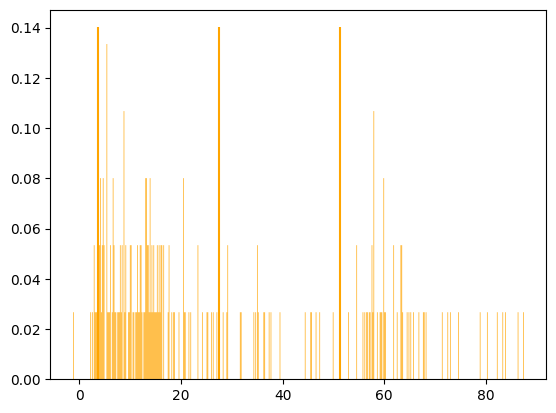

Epoch 0: Loss = 849.1606262


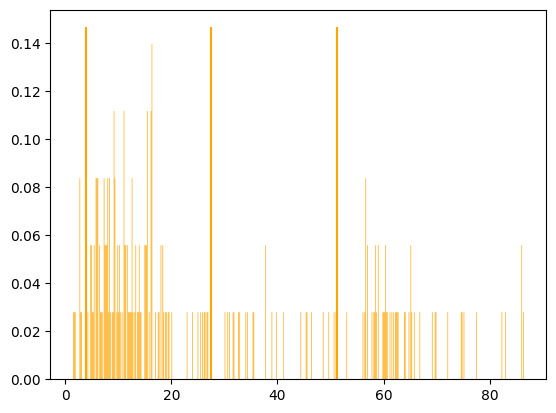

Epoch 1: Loss = 832.9865228


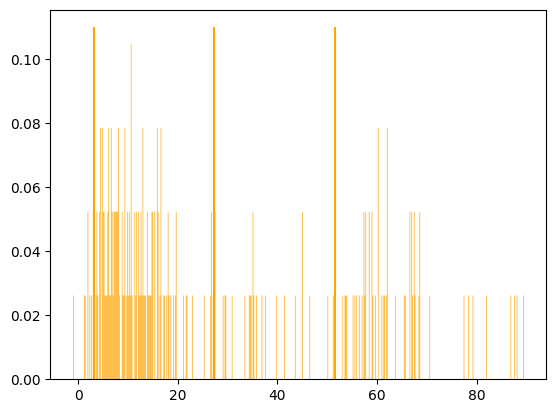

Epoch 2: Loss = 880.7385064


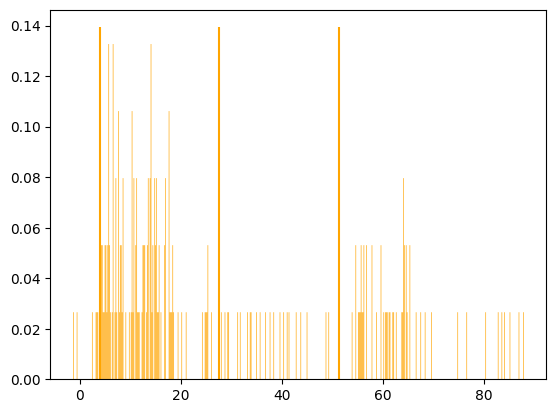

Epoch 3: Loss = 858.4747084


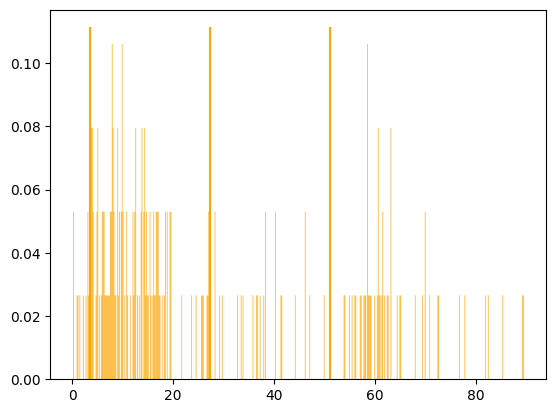

Epoch 4: Loss = 830.6302148


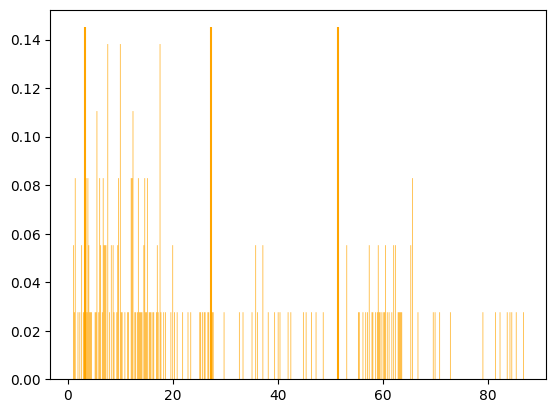

Epoch 5: Loss = 852.2928299


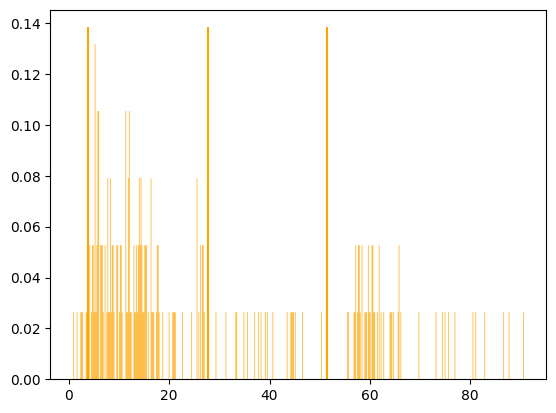

Epoch 6: Loss = 854.2955148


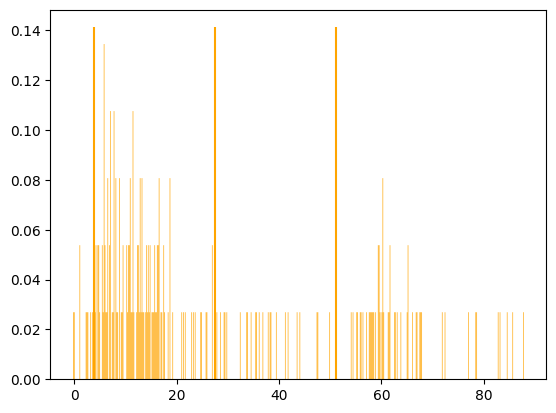

Epoch 7: Loss = 810.6483335


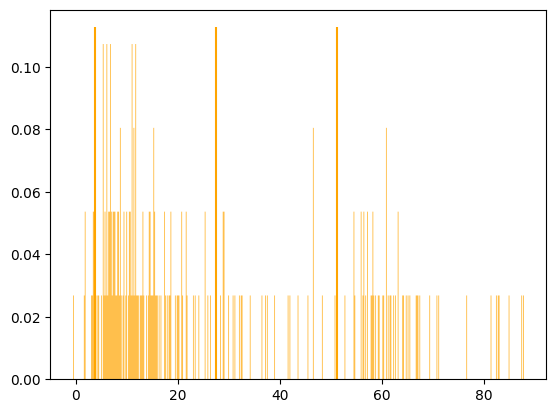

Epoch 8: Loss = 860.5690719


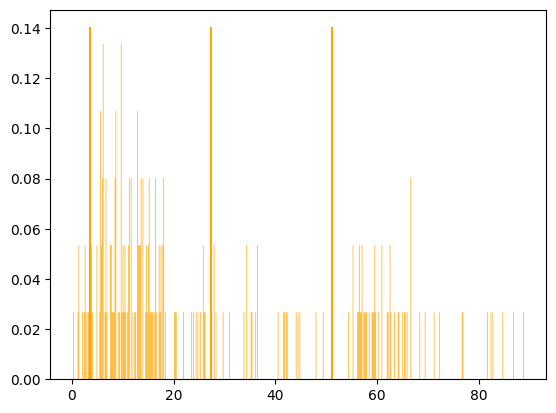

Epoch 9: Loss = 849.4928522


In [7]:
tickers = pd.read_csv("bats_symbols.csv")["Name"]
parameter_names = ["r", "q", "theta", "xi", "kappa"]
for ticker in tickers:
    
    prices = get_prices(ticker)
    trajectories, volatilities = get_trajectories(prices)

    train_loop(10, trajectories, volatilities)
    
    break